In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
import tensorflow as tf
from tensorflow.keras import layers
import time

In [2]:
class GAN:
    def __init__(self):
        self.latent_dim = 10
        self.generator_vector_size = 8
        self.discriminator_input_shape = (self.generator_vector_size,)
        self.num_examples_to_generate = 16

        self.generator = self.make_generator_model()
        self.discriminator = self.make_discriminator_model()
        self.gan = self.combime_gan(self.generator, self.discriminator)

    def combime_gan(self, g_model, d_model):
        # make weights in the discriminator not trainable
        d_model.trainable = False
        # connect generator and discriminator
        model = tf.keras.Sequential()
        model.add(g_model)
        model.add(d_model)
        opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model

    def make_generator_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(30, use_bias=True, input_dim=self.latent_dim))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Dense(15))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())
        model.add(layers.Dense(self.generator_vector_size, activation='tanh'))

        model.summary()
        return model

        # noise = tf.keras.layers.Input(shape=(self.latent_dim,))
        # g_rows = model(noise)
        # return tf.keras.Model(noise, g_rows)
        # return model

    def make_discriminator_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Dense(32, use_bias=True, input_shape=self.discriminator_input_shape))
        # model.add(layers.Dense(32, use_bias=False, input_shape=(8,)))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.2))

        model.add(layers.Dense(16))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.2))

        model.add(layers.Flatten())
        model.add(layers.Dense(1, activation='sigmoid'))
        opt = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        model.summary()
        return model

        # g_rows = tf.keras.layers.Input(shape=self.discriminator_input_shape)
        # validity = model(g_rows)
        # return tf.keras.Model(g_rows, validity)


    def train(self, df, epochs, batch_size=8):
        # (X_train, _), (_, _) = mnist.load_data()
        # X_train = X_train / 127.5 - 1.
        # X_train = np.expand_dims(X_train, axis=3)
        X_train = df.values
        valid = np.ones((batch_size, 1))
        valid_twice = np.ones((batch_size * 2, 1))
        fake = np.zeros((batch_size, 1))
        d_losses = np.zeros((epochs, 1))
        d_accuracies = np.zeros((epochs, 1))
        g_losses = np.zeros((epochs, 1))
        g_accuracies = np.zeros((epochs, 1))

        d_fake_losses = np.zeros((epochs, 1))
        d_fake_accuracies = np.zeros((epochs, 1))
        d_real_losses = np.zeros((epochs, 1))
        d_real_accuracies = np.zeros((epochs, 1))

        for i, epoch in enumerate(range(epochs)):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            rows = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_rows = self.generator.predict(noise)
            d_loss_real, d_acc_real = self.discriminator.train_on_batch(rows, valid)
            d_loss_fake, d_acc_fake = self.discriminator.train_on_batch(gen_rows, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            d_acc = 0.5 * np.add(d_acc_real, d_acc_fake)

            d_fake_losses[i] = d_loss_fake
            d_real_losses[i] = d_loss_real
            d_fake_accuracies[i] = d_acc_fake
            d_real_accuracies[i] = d_acc_real

            # train on twice batch_size because we do that for discriminator as well 
            noise_twice = np.random.normal(0, 1, (batch_size * 2, self.latent_dim))
            # create inverted labels for the fake samples so generator can improve to be 'real'
            # update the generator via the discriminator's error
            g_loss, g_acc = self.gan.train_on_batch(noise_twice, valid_twice)

            d_losses[i] = d_loss
            d_accuracies[i] = d_acc
            g_losses[i] = g_loss
            g_accuracies[i] = g_acc
            if i % 50 == 0:
              print("epoch %d [D loss: %f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]" % (epoch, d_loss, 100 * d_acc, g_loss, g_acc))
              if 800<=i and i<= 1200:
                filename = 'generator_model_%03d.h5' % (epoch + 1)
                self.generator.save(filename)

            # if epoch % 10 == 0:
            #   noise = np.random.normal(0, 1, (1, self.noise_dim))
            #   gen_rows = self.generator.predict(noise)
            #   print(gen_rows)
        return d_losses, d_accuracies, g_losses, g_accuracies, d_fake_losses, d_real_losses, d_fake_accuracies, d_real_accuracies

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
diab_arf = arff.loadarff('gdrive/MyDrive/DL/Assignment_4/diabetes.arff')

In [5]:
diab_df = pd.DataFrame(diab_arf[0])

In [6]:
# diab_df.replace(to_replace=b'tested_negative', value=-1, inplace=True)
# diab_df.replace(to_replace=b'tested_positive', value=1, inplace=True)

In [7]:
diab_df.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,b'tested_positive'
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,b'tested_negative'
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,b'tested_positive'
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,b'tested_negative'
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,b'tested_positive'


In [8]:
# the values must be scaled to the range [-1,1] to match the output of the generator model
def scaler(df):
  for column in df:
    max = df[column].max()
    min = df[column].min()
    col = 2*((df[column] - min)/(max - min)) - 1
    df[column] = col
  return df

In [9]:
# class is not part of sample description
del diab_df['class']
diab_df = scaler(diab_df)

In [10]:
diab_df.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,-0.547641,0.215020,0.132877,-0.585122,-0.811349,-0.046421,-0.663641,-0.591970
std,0.396421,0.321333,0.317308,0.322267,0.272444,0.234997,0.282945,0.392008
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.882353,-0.005025,0.016393,-1.000000,-1.000000,-0.186289,-0.858454,-0.900000
50%,-0.647059,0.175879,0.180328,-0.535354,-0.927896,-0.046200,-0.748506,-0.733333
75%,-0.294118,0.409548,0.311475,-0.353535,-0.699173,0.090909,-0.531810,-0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                330       
_________________________________________________________________
batch_normalization (BatchNo (None, 30)                120       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                465       
_________________________________________________________________
batch_normalization_1 (Batch (None, 15)                60        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


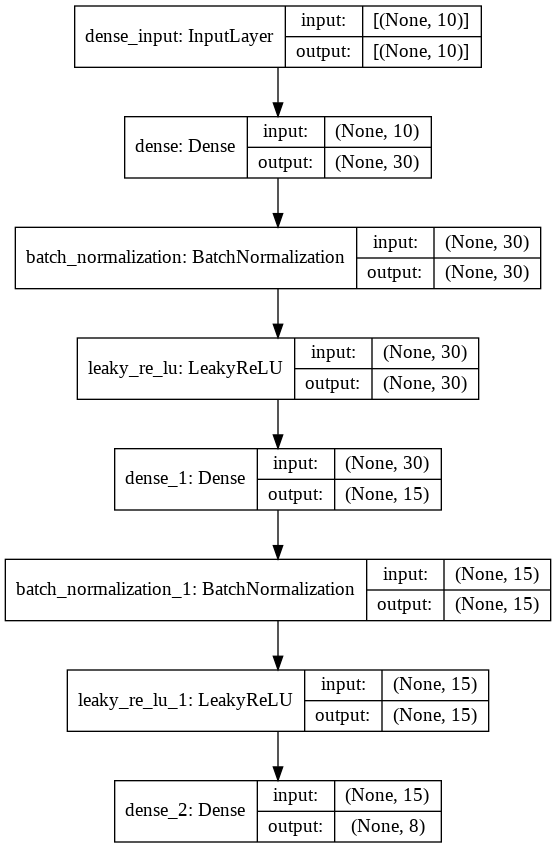

In [11]:
gan = GAN()
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(gan.generator, to_file='g_plot.png', show_shapes=True, show_layer_names=True)

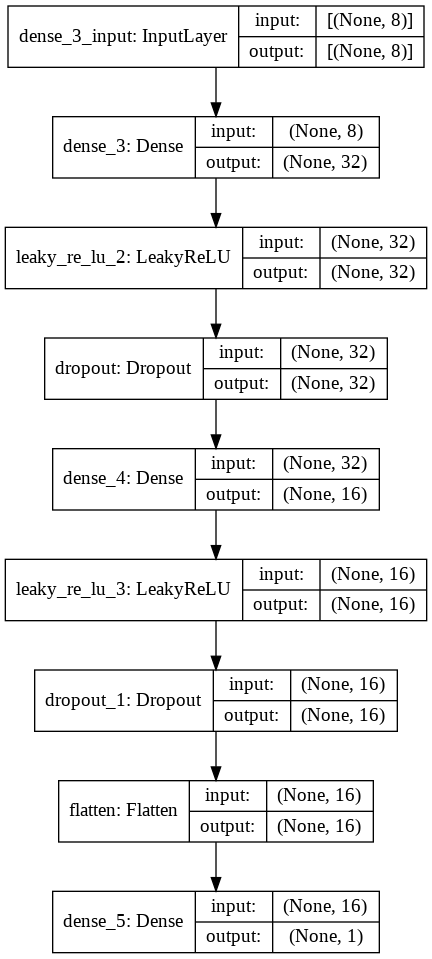

In [12]:
plot_model(gan.discriminator, to_file='d_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
epochs = 10000
d_losses, d_accuracies, g_losses, g_accuracies, d_fake_losses, d_real_losses, d_fake_accuracies, d_real_accuracies = gan.train(df=diab_df, epochs=epochs, batch_size=16)

epoch 0 [D loss: 0.730692, acc.: 40.62%] [G loss: 0.443383, acc.: 1.00%]
epoch 50 [D loss: 0.632560, acc.: 50.00%] [G loss: 0.497562, acc.: 0.97%]
epoch 100 [D loss: 0.536428, acc.: 62.50%] [G loss: 0.593425, acc.: 0.78%]
epoch 150 [D loss: 0.472238, acc.: 81.25%] [G loss: 0.652683, acc.: 0.62%]
epoch 200 [D loss: 0.461669, acc.: 65.62%] [G loss: 0.683685, acc.: 0.53%]
epoch 250 [D loss: 0.476257, acc.: 65.62%] [G loss: 0.786135, acc.: 0.50%]
epoch 300 [D loss: 0.406274, acc.: 87.50%] [G loss: 0.811518, acc.: 0.41%]
epoch 350 [D loss: 0.338623, acc.: 87.50%] [G loss: 0.882761, acc.: 0.34%]
epoch 400 [D loss: 0.413695, acc.: 87.50%] [G loss: 0.843031, acc.: 0.44%]
epoch 450 [D loss: 0.448043, acc.: 78.12%] [G loss: 0.835712, acc.: 0.34%]
epoch 500 [D loss: 0.441221, acc.: 81.25%] [G loss: 0.790082, acc.: 0.44%]
epoch 550 [D loss: 0.491450, acc.: 68.75%] [G loss: 0.775387, acc.: 0.41%]
epoch 600 [D loss: 0.553948, acc.: 68.75%] [G loss: 0.793736, acc.: 0.41%]
epoch 650 [D loss: 0.548471,

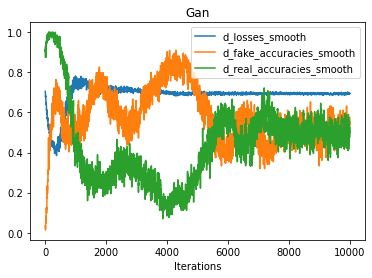

In [14]:
# when to stop: once “good enough” images can be generated, 
# the subjective quality of the images may then begin to vary, improve, or even degrade with subsequent updates.
from typing import List

def plot_metric_general(graphs: List[np.ndarray], labels: List[str]) -> None:
    import matplotlib.pyplot as plt
    epochs = range(1, graphs[0].shape[0] + 1)
    plt.xlabel("Iterations")
    plt.title('Gan')
    for i in range(len(labels)):
        plt.plot(epochs, graphs[i])
    plt.legend(labels)
    plt.show()

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
  
d_losses_smooth, d_fake_accuracies_smooth, d_real_accuracies_smooth = moving_average(d_losses.reshape((epochs)), 9), moving_average(d_fake_accuracies.reshape((epochs)), 9), moving_average(d_real_accuracies.reshape((epochs)), 9)

plot_metric_general([d_losses_smooth, d_fake_accuracies_smooth, d_real_accuracies_smooth], ['d_losses_smooth', 'd_fake_accuracies_smooth', 'd_real_accuracies_smooth'])
# we can see aroud 800 epochs d_fake_accuracies=d_real_accuracies=0.5 and after that it degragates 

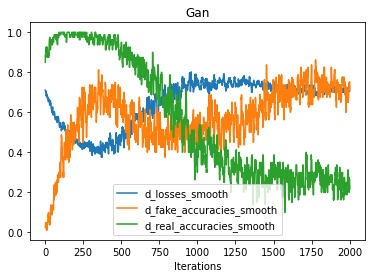

In [15]:
d_losses_smooth, d_fake_accuracies_smooth, d_real_accuracies_smooth = moving_average(d_losses.reshape((epochs)), 5), moving_average(d_fake_accuracies.reshape((epochs)), 5), moving_average(d_real_accuracies.reshape((epochs)), 5)
plot_metric_general([d_losses_smooth[:2000], d_fake_accuracies_smooth[:2000], d_real_accuracies_smooth[:2000]], ['d_losses_smooth', 'd_fake_accuracies_smooth', 'd_real_accuracies_smooth'])
# we can see aroud 800 iteration d_fake_accuracies=d_real_accuracies=0.5 and after that they wobbles one against the other

In [16]:
# import matplotlib.pyplot as plt
# def show_plot(arr):
#   x = range(arr.shape[0])
#   plt.plot(x, arr)

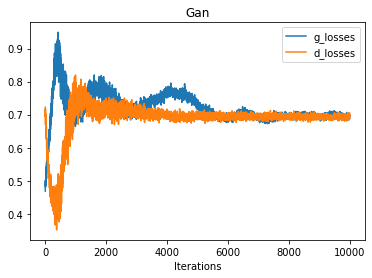

In [17]:
g_losses_smooth, d_losses_smooth = moving_average(g_losses.reshape((epochs)), 3), moving_average(d_losses.reshape((epochs)), 3)
# graph describing the loss of the generator and the discriminator
# models go “back and forth” with their losses, there was no a consistent leader
plot_metric_general([g_losses_smooth, d_losses_smooth], ['g_losses', 'd_losses'])

In [18]:
# show_plot(d_accuracies)

In [19]:
# show_plot(g_accuracies)


In [20]:
X_train = diab_df.values
y_real = np.ones((X_train.shape[0], 1))

# evaluation experiment on diabetes
print ('real evaluation experiment on all data set')
_, acc_real = gan.discriminator.evaluate(X_train, y_real, verbose=1)
y_fake = np.zeros((100, 1))
noise = np.random.normal(0, 1, (100, gan.latent_dim))
x_fake =gan.generator.predict(noise)
print ('fake evaluation experiment on 100 samples')
_, acc_facke = gan.discriminator.evaluate(x_fake, y_fake, verbose=1)

real evaluation experiment on all data set
24/24 [==============================] - 0s 2ms/step - loss: 0.6958 - accuracy: 0.3880
fake evaluation experiment on 100 samples
4/4 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.6800


In [31]:
gan.generator.save('generator_model_10000.h5')

In [32]:
# we can check for models checkpoints produced good generative samples
loaded_generator = tf.keras.models.load_model('generator_model_10000.h5')
noise = np.random.normal(0, 1, (100, gan.latent_dim))
x_fake = loaded_generator.predict(noise)
# print('x_fake \n', x_fake)
print ('fake loaded_generator evaluation experiment on 100 samples')
_, acc_facke = gan.discriminator.evaluate(x_fake, y_fake, verbose=1)


fake loaded_generator evaluation experiment on 100 samples
4/4 [==============================] - 0s 3ms/step - loss: 0.6862 - accuracy: 0.7100
